# SpaceEye
Satellite imagery is essential for a wide range of applications, including disaster management and recovery, agriculture, and military intelligence. Clouds are a severe impediment to all of these use cases, so they usually be identified and removed from a dataset before satellite images can be utilized. 

The tutorial uses SpaceEye data, which neural-network-based solution to recover pixels occluded by clouds in satellite images. Space Eye leverage radio frequency (RF) signals in the ultra/super-high frequency band that penetrate clouds to help reconstruct the occluded regions in multispectral images. We introduce the first multi-modal multi-temporal cloud removal model that uses publicly available satellite observations and produces daily cloud-free images. 

Space Eye provides 10 bands of the 13 original bands from Sentinel-2: 



| Band                                  |
    |---------------------------------------|
    | Band 2[0] - Blue                         |
    | Band 3[1] - Green                        |
    | Band 4[2] - Red                          |
    | Band 5[3] - Vegetation red edge (VRE)          |
    | Band 6[4] - Vegetation red edge (VRE) |
    | Band 7[5] - Vegetation red edge (VRE) |
    | Band 8[6] - Near infrared (NIR)                 |
    | Band 8A[7] - Narrow band NIR                        |
    | Band 11[8] - Short wave infrared (SWIR)                     |
    | Band 12[9] - Short wave infrared (SWIR)                      |


Below are the main libraries used for this project and other useful links:
- [Geopandas](https://github.com/geopandas/geopandas) is an extension of the popular pandas library to add support for geographic data. It uses shapely objects in its geometry column, and understands coordinate systems. We use it to visualize the training/validation RoIs. It is also quite useful for transforming geometries between different CRSs.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.
- [seaborn](https://seaborn.pydata.org/) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- [pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing in python. It's a python library that is used for working with arrays and contains random number generators. It also has functions for working in the domain of linear algebra, Fourier transforms, and matrices, etc.

# Imports

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns

from rasterio.mask import mask
from rasterio.plot import show
from skimage import exposure

# Explore the data
Hackathon data is already available within the blob storage. You have to download the data using either the word document tutorial or the following command: 

Let's start by selecting one of the SpaceEye data available. We will select date 2019-08-15 from grid 34. **Make sure to download the data from the blob storage first**

In [2]:
ROOT_DIR = "/mnt/data"  # Change this to where you stored the data
path = os.path.join(ROOT_DIR, "spaceeye-data/spaceeye_data/34/20190101_20191231/pogan/pogan_s2_20190815.tif")

The first three bands from SpaceEye data represent the Blue, Green and Red channels with 10m resolution and central wavelenght 490 nm, 560 nm and 665 nm, respectively. We can visualize each band bellow:

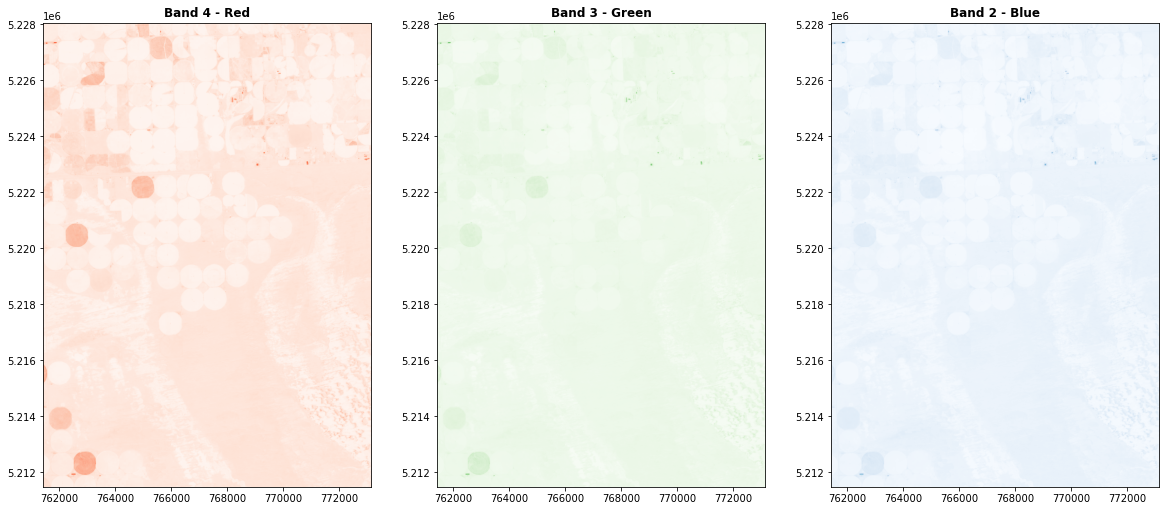

In [3]:
with rasterio.open(path) as src:
    image = src.read()
    fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(20, 10))
    show((src, 3), ax=axr, cmap='Reds', title='Band 4 - Red')
    show((src, 2), ax=axg, cmap='Greens', title='Band 3 - Green')
    show((src, 1), ax=axb, cmap='Blues', title='Band 2 - Blue')
    plt.show()

We can make a composite image from the three visible bands (blue, green, and red) to visualize a true color image using only `rasterio`. Due to the presence of outliers in the raw input, we do some post-processing to obtain a true color image.

In [4]:
def true_color(image, percentile=(0.5, 99.5), gamma=0.7, rgb_bands=[2, 1, 0]):
    img = image[rgb_bands].transpose([1, 2, 0]) / image.max()
    img = np.clip(img, a_min=0.0, a_max=1.0) * 255.0
    plow, phigh = np.percentile(img, percentile)
    if phigh>plow:
        x_ = exposure.rescale_intensity(img, in_range=(plow, phigh))
        y_ = x_ ** gamma
        img = (y_*255)
    return img.astype(np.uint8)

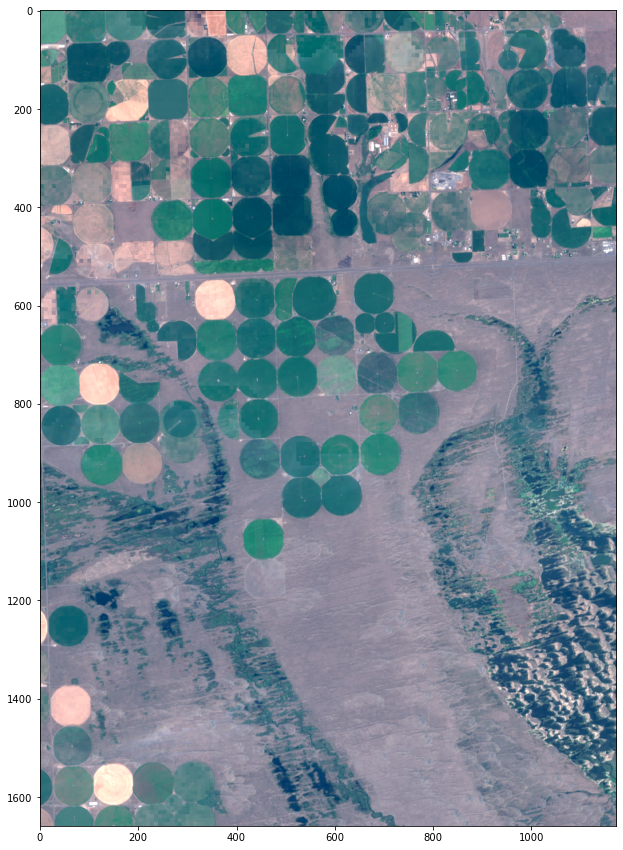

In [5]:
plt.figure(figsize=(15,15))
plt.imshow(true_color(image))
plt.show()

Let's visualize the histograms of the color channels to see the effect of the post-processing method. Note how it improves the dynamic range (which leads to much clearer images). We can also see peaks in 0 and 255, which are due to the clipping of outliers.

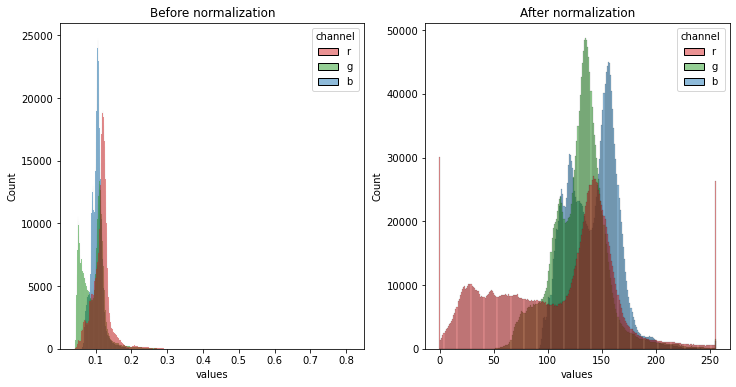

In [6]:
r, g, b = image[[3, 2, 1]].reshape(3, -1)
r_c, g_c, b_c = true_color(image).transpose((2, 0, 1)).reshape(3, -1).astype("float32")
pixels = pd.DataFrame([(cc, n) for c, n in zip((r, g, b), ("r", "g", "b")) for cc in c], columns=["values", "channel"])
pixels_c = pd.DataFrame([(cc, n) for c, n in zip((r_c, g_c, b_c), ("r", "g", "b")) for cc in c], columns=["values", "channel"])

palette = sns.color_palette()
palette = [palette[i] for i in (3, 2, 0)]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=pixels, x="values", hue="channel", palette=palette)
plt.title("Before normalization")
plt.subplot(1, 2, 2)
sns.histplot(data=pixels_c, x="values", hue="channel", palette=palette, bins=np.linspace(0, 256., 257) -.5)
plt.title("After normalization")
plt.show()

# Calculating the NDVI

The Normalized Difference Vegetation Index (NDVI) is a vegetation index widely used for environmental impact assessment, agricultural evaluation, and land use change metrics. It evaluates vegetation by estimating the contrast between near infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). NDVI always ranges from -1 to +1, but there isn’t a distinct boundary for each type of land cover. For instance, when you have negative qualities, almost certainly, it’s water. Then again, if you have an NDVI value near +1, there’s a high chance that it’s thick green leaves. NDVI values near zero indicate the absence of vegetation, such as in urbanized zones or bare lands. NDVI is calculated using both red and NIR bands:

$\mathrm{NDVI} = \left( \frac{\mathrm{NIR} - \mathrm{RED}}{\mathrm{NIR} + \mathrm{RED}} \right)$

For Sentinel 2, those are bands 4 and 8, respectively. Since SpaceEye does not have B01, those are bands 3 and 7 (2 and 6 for 0-indexes arrays such as in numpy).

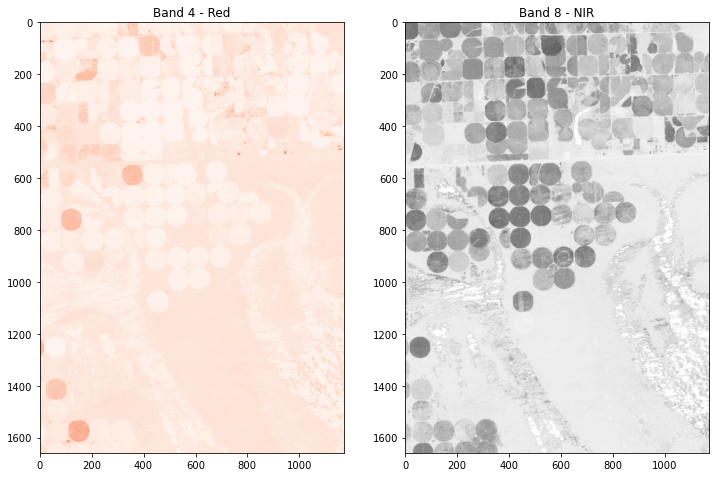

In [7]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[2], cmap="Reds")
plt.title("Band 4 - Red")
plt.subplot(1, 2, 2)
plt.imshow(image[6], cmap="Greys")
plt.title("Band 8 - NIR")
plt.show()

In [8]:
def ndvi(image):
    red = image[2].astype(float)
    nir = image[6].astype(float)
    return np.where((nir + red) == 0.,0, (nir - red) / (nir + red)) 

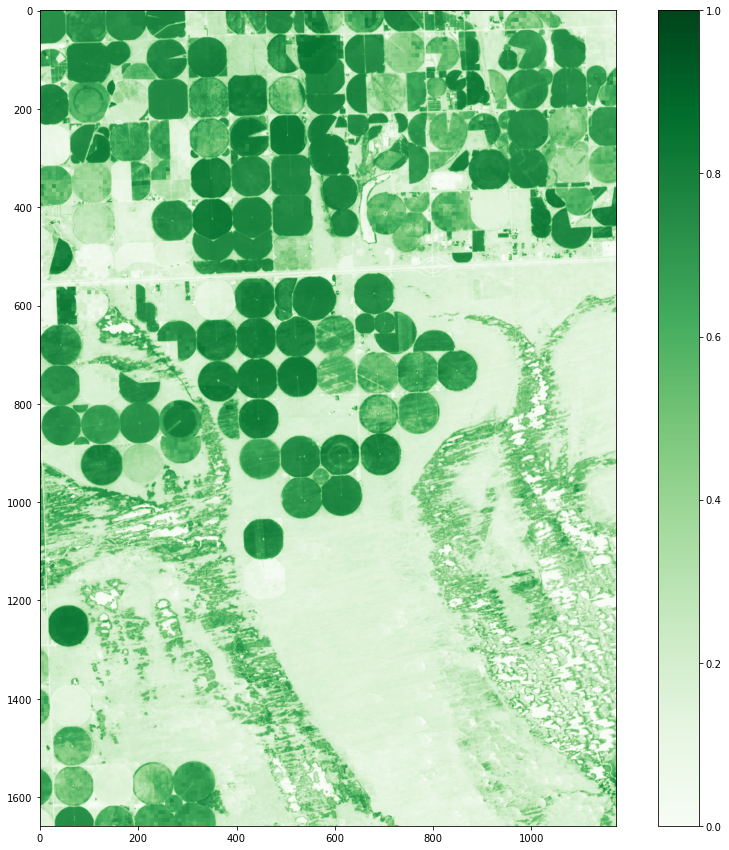

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(ndvi(image),cmap='Greens',vmin=0,vmax=1)
plt.colorbar()
plt.show()

# Exploring the prepared (NDVI) data
We have provided two files, which are a complete version of the NDVI calculated with SpaceEye data for the region. Each band represents NDVI of a day, starting from the first, with an interval of 10 days between each band. Both files have 37 bands.

In [10]:
path_ndvi = os.path.join(ROOT_DIR, "ndvi_stack_2020_10.tif")

In [11]:
with rasterio.open(path_ndvi) as src:
    one_day = src.read(13) 

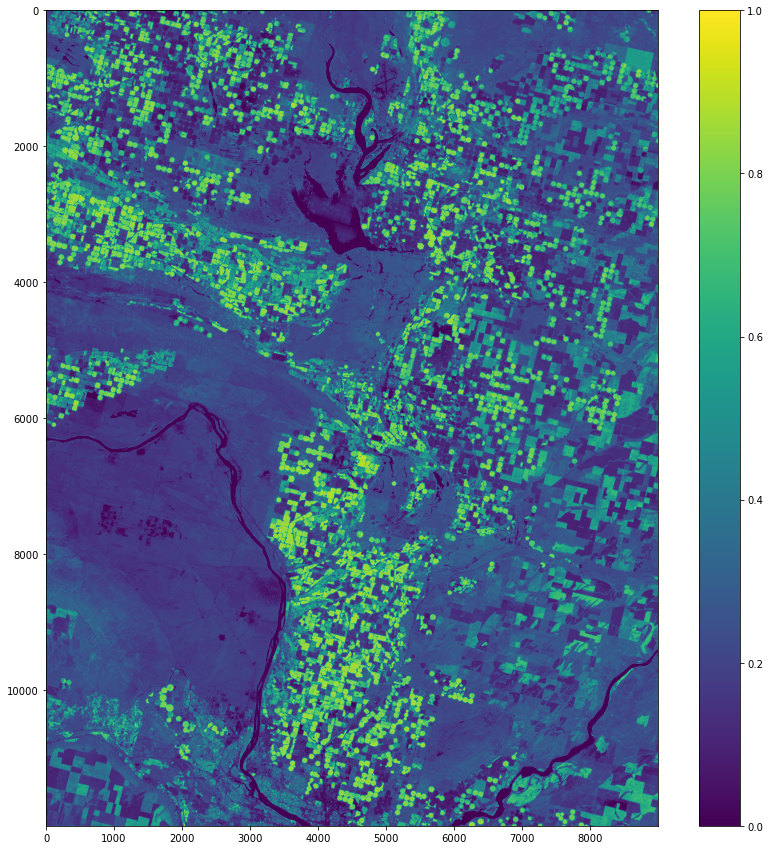

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(one_day,vmin=0,vmax=1)
plt.colorbar()
plt.show()

# Analyzing one field

We can also analyze the time series of the NDVI and how it evolves over time. We have annotated a few potato fields in the area of interest, which can be found in the `annotations.geojson` file.

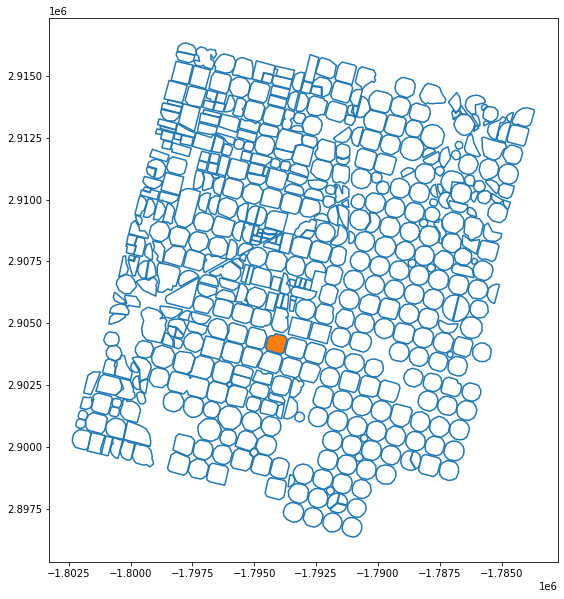

In [18]:
with rasterio.open(path_ndvi) as src:
    crs = src.crs

# Read GeoJSON file using geopandas
annotations = gpd.read_file("annotations.geojson", crs=crs)
plt.figure(figsize=(10, 10))
ax = plt.gca()
annotations.boundary.plot(ax=ax)
fields = annotations.geometry.iloc[4:5]
fields.plot(ax=ax,color='C1')
plt.show()

We can select one specific field to make the analysis easier.

<AxesSubplot:>

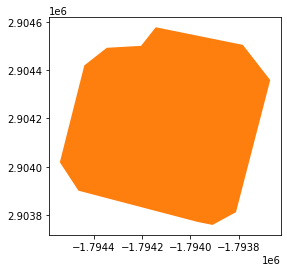

In [19]:
fields.plot(color="C1")

In [16]:
filepaths = [path_ndvi]

masked = [[] for _ in fields]
for filepath in filepaths:
    with rasterio.open(filepath) as src:
        for s, m in zip(fields, masked):
            masked_ar = mask(src, [s], all_touched=True, filled=False, crop=True)[0]
            m.append(masked_ar.compressed().reshape(37, -1))
masked = [np.stack(m) for m in masked]

This is the NDVI for the field in four different dates

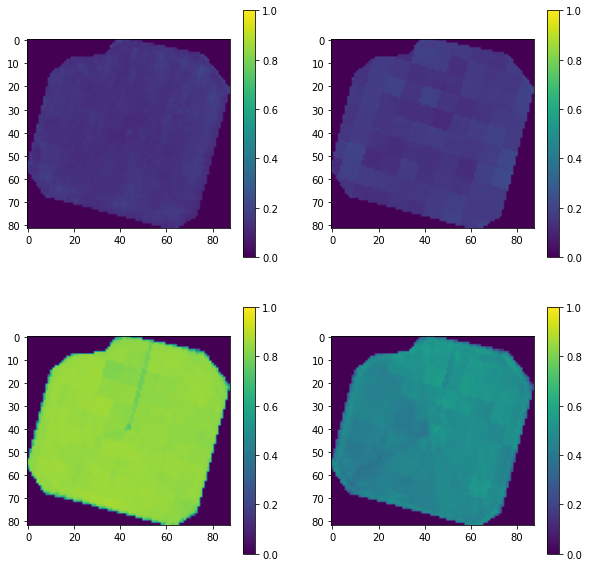

In [17]:
filled_ar = masked_ar.filled(0)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(filled_ar[0],vmin=0,vmax=1)
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(filled_ar[12],vmin=0,vmax=1)
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(filled_ar[18],vmin=0,vmax=1)
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(filled_ar[36],vmin=0,vmax=1)
plt.colorbar()
plt.show()

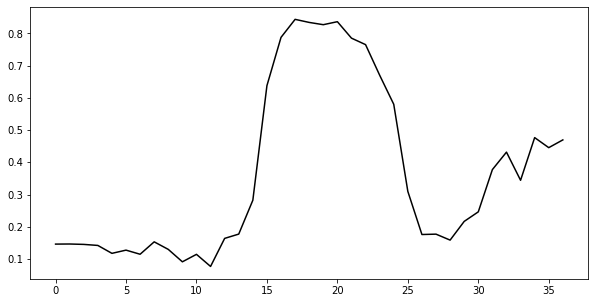

In [19]:
# Plot the mean value of the field over time
plt.figure(figsize=(10, 5))
plt.plot(masked[0].mean(axis=(0, 2)),color='black')
plt.show()